## MLGIG Team –  Milk Lactose Prediction Data Challenge
4th International Workshop on Spectroscopy and Chemometrics 2024, organised by the VistaMilk SFI Research Centre

Data description:

A total of 72 milk samples were analysed using hyperspectral imaging. The number of pixels considered for each sample ranges from 112 to 300. For each pixel, a spectrum containing 3,424 wavelengths in the range from 400 cm-1 to 7,000 cm-1 was generated. For each sample, the spectra were extracted from the pixels and included into a single dataset, therefore the spatial information were successively lost.  
** Target: For each sample the lactose concentration was analysed and expressed as mg/mL. **

Data provided:

Training set covariates: an excel file with 64 different sheets, each one corresponding to a different sample. Each sheet corresponds to a data matrix with ni rows and p = 3424 columns, corresponding to the spectra for the ni considered pixels for the i-th sample. 
Training set response: an excel file containing the information on the lactose content for the samples included in the training set. 
Test set covariates: an excel file with 8 different sheets, with the same structure as the training set covariates but without the information on the lactose content. 

Task:

Participants should develop prediction models to quantify the lactose content employing the spectral information. Each participant should send a csv file to maria.frizzarin@teagsc.ie with the predicted lactose contents for the samples in the test set. 

Tips:

For each sample there are both outlier spectra and noise regions to be deleted before the development of the prediction model. 

Details about event:
https://www.eventbrite.com/e/international-workshop-on-spectroscopy-chemometrics-tickets-844689056707?keep_tld=1

In [2]:
import pandas as pd
import numpy as np
#from numpy import zeros, newaxis
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#sns.set()
import os, sys
import time
import timeit
#linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_decomposition import PLSRegression

#ensembles
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

#knn
from sklearn.neighbors import KNeighborsRegressor

#neural networks
from sklearn.neural_network import MLPRegressor

#svm: try both linear kernel and rbf kernel
from sklearn.svm import SVR

#deep neural networks aka deep learning
#tbd: initial results by Ashish did not look good

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
#from patsy import dmatrices
from sklearn.utils import shuffle
#from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedKFold

from sklearn import preprocessing
from scipy.interpolate import interp1d

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.feature_selection import SelectKBest, f_regression

#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
#For showing plots directly in the notebook run the command below
%matplotlib inline
# For saving multiple plots into a single pdf file
from matplotlib.backends.backend_pdf import PdfPages

import plotly.express as px
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


from aeon.transformations.collection.convolution_based import Rocket, MiniRocket, HydraTransformer,  MultiRocket, MiniRocketMultivariate, MultiRocketMultivariate
from aeon.transformations.collection.interval_based import QUANTTransformer, RandomIntervals
from aeon.transformations.collection.shapelet_based import RandomDilatedShapeletTransform, RandomShapeletTransform

from aeon.regression.deep_learning import CNNRegressor, FCNRegressor, ResNetRegressor, IndividualInceptionRegressor, MLPRegressor
from aeon.regression.interval_based import TimeSeriesForestRegressor, DrCIFRegressor	
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor
from aeon.regression.shapelet_based import RDSTRegressor
from aeon.regression.feature_based import FreshPRINCERegressor	
from aeon.regression.hybrid import RISTRegressor

from sklearn.ensemble import ExtraTreesRegressor

#Quant, Hydra, Weasel2, MrSQM

from aeon.transformations.difference import Differencer

#package for ordinal regression
import mord

from aeon.classification.ordinal_classification import OrdinalTDE
#from aeon.classification.interval_based import QUANTClassifier
#from aeon.classification.convolution_based import HydraClassifier
#from aeon.classification.dictionary_based import MUSE

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIG_SIZE = 12

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import mrsqm

plt.rc('font', size=BIG_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIG_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title

np.set_printoptions(precision=2)


OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [27]:
# https://www.aeon-toolkit.org/en/stable/examples/classification/classification.html
# From aeon: We recommend storing time series in 3D numpy array of shape (n_instances, n_channels, n_timepoints) 
# and where possible our single problem loaders will return a 3D numpy.

# load each sample in a 3d numpy array (n_samples, n_channels, n_timepoints)
train_X = np.load("train_X.npy")
test_X = np.load("test_X.npy")

print(train_X.shape)
print(train_X[0])

print(test_X.shape)
print(test_X[0])


(64, 300, 3424)
[[ 7.68  7.45  5.71 ... 17.2  16.8  17.05]
 [12.72 13.25 16.81 ... 12.28 12.07 11.97]
 [ 7.11  6.66  4.77 ...  6.5   6.87  6.93]
 ...
 [ 6.41 10.28  8.99 ... 11.85 12.02 11.93]
 [40.98 42.95 52.84 ... 26.09 25.99 26.13]
 [27.4  37.22 33.08 ... 35.88 36.   35.62]]
(8, 300, 3424)
[[ 0.83  2.42  2.8  ...  8.19  8.19  8.21]
 [ 3.05  1.11  0.41 ...  6.38  6.32  6.21]
 [ 0.68 -0.18  1.5  ...  6.74  6.72  6.76]
 ...
 [ 0.54  1.83  2.31 ...  7.84  7.88  7.89]
 [-0.4   1.26  1.39 ... 10.82 10.74 10.7 ]
 [ 3.36  4.45  4.21 ... 10.95 10.86 10.94]]


In [4]:
train_targets = pd.read_excel('train_targets.xlsx', 0, engine='openpyxl')
print(train_targets.shape)
print(train_targets)

train_y = train_targets['lactose content']
print(train_y)

(64, 2)
   sample number  lactose content
0      sample01                72
1       sample02               62
2       sample04               60
3       sample05               48
4       sample06               24
..           ...              ...
59      sample68               48
60      sample69               48
61      sample70               24
62      sample71               19
63      sample72               72

[64 rows x 2 columns]
0     72
1     62
2     60
3     48
4     24
      ..
59    48
60    48
61    24
62    19
63    72
Name: lactose content, Length: 64, dtype: int64


In [5]:
train_y.describe()

count    64.000000
mean     46.500000
std      18.775195
min      19.000000
25%      27.750000
50%      53.000000
75%      60.500000
max      72.000000
Name: lactose content, dtype: float64

<Axes: >

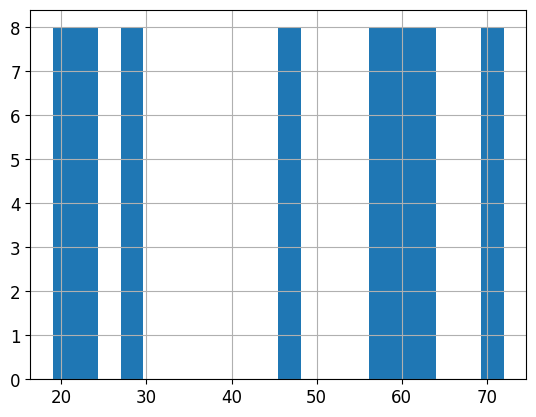

In [6]:
train_y.hist(bins = 20)

In [7]:
train_y.sort_values().value_counts()

lactose content
19    8
24    8
29    8
48    8
58    8
60    8
62    8
72    8
Name: count, dtype: int64

In [8]:
def plotWaves(df, features, target, out_file="plot_sample.png"):

    plt.figure(figsize=(20, 5))
    
    plt.plot(df[features].T, color='LightBlue')
    plt.plot(df[features].mean().T, color='Red')
    
    #plt.xticks(rotation=45, ha='right')
    #plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
    #plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    #plt.vlines(540, ymin=0, ymax=4.5, color='black', linestyle='--')
    plt.title('Matrix sample and overall column-wise mean')
    plt.legend(target)
    #plt.grid()
    plt.savefig(out_file)
    
#if __name__ == "__main__":
#    plotWaves(df = df, features = df.columns, target=19)

sample: 0
sample: 1
sample: 2


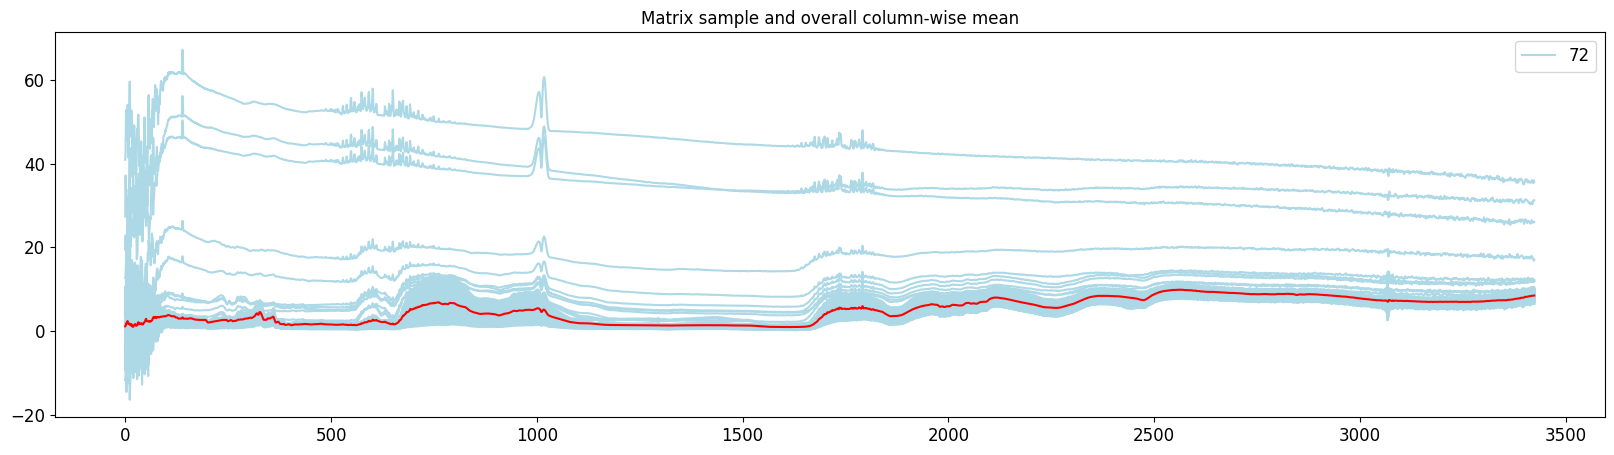

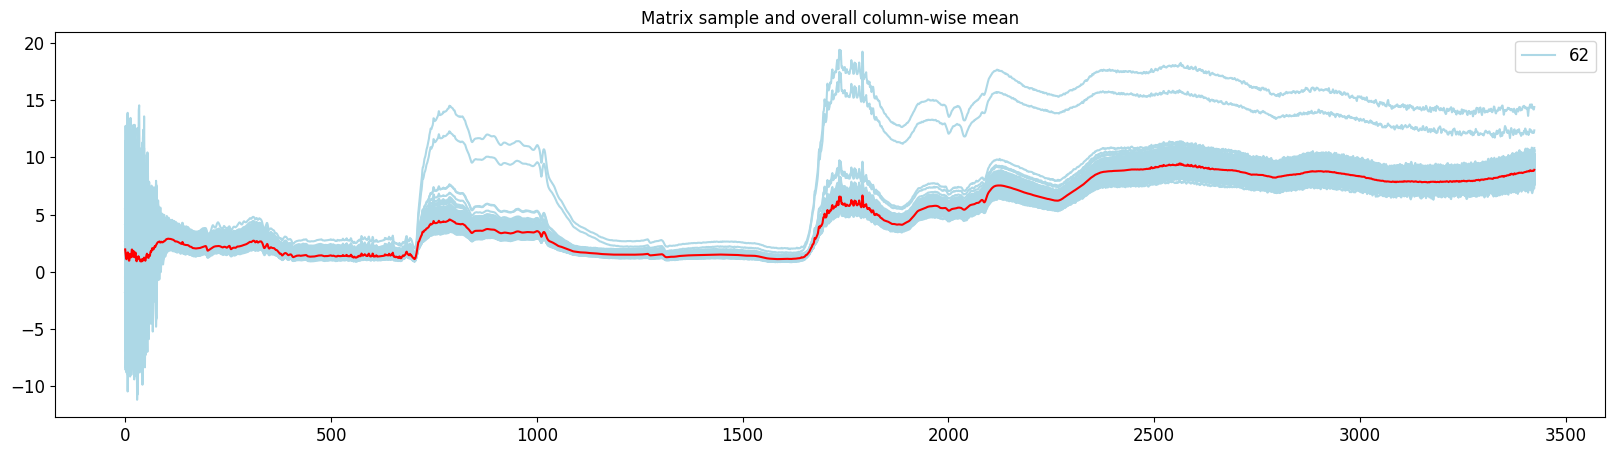

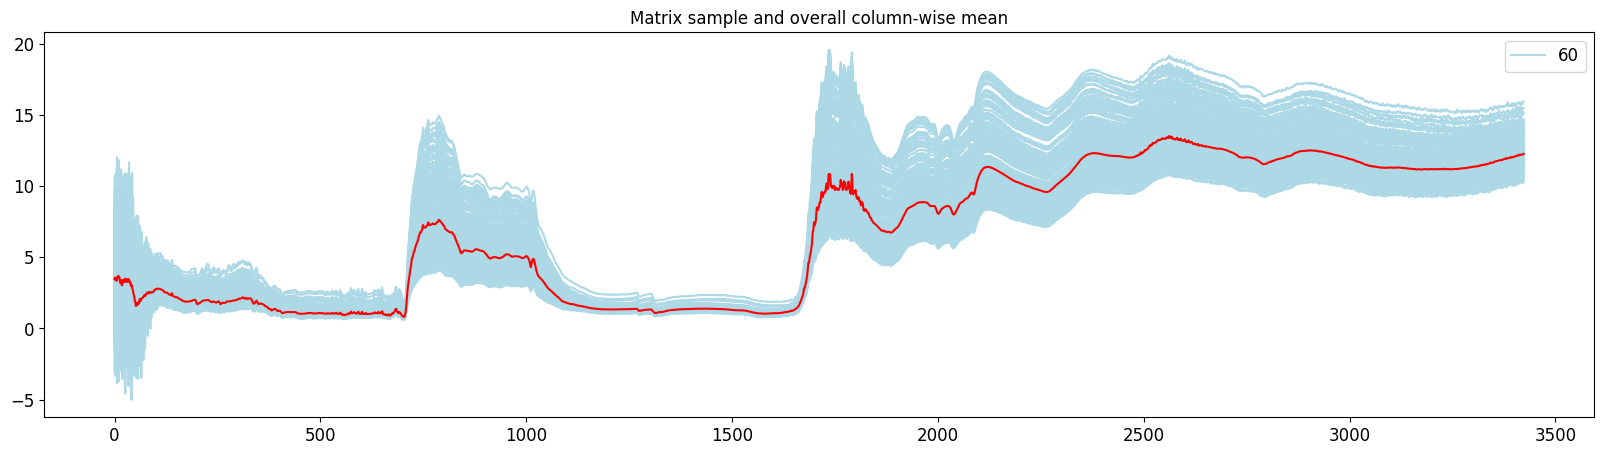

In [9]:
for sample in range(3):
    print("sample:", sample)
    df = pd.DataFrame(train_X[sample])
    #print(df)
    #print(df.describe().T)
    #print(train_y[sample])
    plotWaves(df = df, features = df.columns, target = [str(train_y[sample])], out_file="plot_train_sample" + str(sample) + "-target" + str(train_y[sample]))
    #plotWaves(df = df, features = df.columns, target = ["NA"], out_file="plot_test_sample" + str(sample) + "-target-na")


In [10]:
y_pred = [train_y.mean()] * len(train_y)
print(f'Baseline RMSE: {math.sqrt(mean_squared_error(train_y, y_pred))}')

Baseline RMSE: 18.627936010197157


In [11]:
def single_split_experiment(X, y, model, test_split = 0.25, random_state = 42, stratify = None):
    #rng = np.random.default_rng(random_state)    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=random_state, stratify=stratify, shuffle=True)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    #print(rmse, r2, y_pred, y_test)
    return rmse, r2, y_pred, y_test

In [12]:
def cv_experiment(X, y, model, cv=4, random_state = 42, features = None):

    #rng = np.random.default_rng(random_state)  
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state= random_state)
    scores = cross_validate(model, X, y, cv=skf, scoring=('r2', 'neg_mean_squared_error'))
    
    rmse = np.sqrt(-scores['test_neg_mean_squared_error'])
    r2 = scores['test_r2']
    
    return rmse,r2

## Pre-process Data: Convert 2d sample to 1d sample (eg mean or percentile) or subset of pixels in 2d sample

In [13]:
def normalize_vector(channel: np.ndarray) -> np.ndarray:
    """
    Normalize a vector to have zero mean and unit variance.
    """
    if channel.std() == 0:
        return channel - channel.mean()
    return (channel - channel.mean()) / channel.std()

    #return (channel - channel.mean())

def convert_3d_to_2d_concat(X) -> np.ndarray:
    if isinstance(X, pd.DataFrame):
        X = from_nested_to_3d_numpy(X)

    X_2d = np.zeros((X.shape[0], X.shape[1] * X.shape[2]))

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            #X_2d[i, j * X.shape[2] : (j + 1) * X.shape[2]] = normalize_vector(X[i, j, :])
            X_2d[i, j * X.shape[2] : (j + 1) * X.shape[2]] = X[i, j, :]

    return X_2d

def convert_3d_to_2d_percentile(X, perc = 25) ->  np.ndarray:
    X_2d_perc = np.zeros((X.shape[0], X.shape[2]))

    for i in range(X.shape[0]):
        X_2d_perc[i, :] = np.percentile(X[i,:,:], q = perc, axis = 0)

    return X_2d_perc

def convert_3d_to_2d_mean(X) ->  np.ndarray:
    X_2d_mean = np.zeros((X.shape[0], X.shape[2]))

    for i in range(X.shape[0]):
        X_2d_mean[i, :] = np.mean(X[i,:,:], axis = 0)

    return X_2d_mean

#From a 3d numpy array, compute percentiles and mean of channels, than put them together in a new 3d numpy array
#This should reduce noise and outliers in the data, but allow the sample to preserve info about mean and variance.
def convert_3d_to_3d_subset(X, percentiles = [25, 50, 75], add_mean = False) ->  np.ndarray:
    
    if add_mean == False:
        X_3d_subset = np.zeros((X.shape[0], len(percentiles), X.shape[2]))
        for i in range(X.shape[0]):
            X_subset = np.percentile(X[i, :, :], q = percentiles, axis = 0)
            X_3d_subset[i, :, :] = X_subset
    else: 
        X_3d_subset = np.zeros((X.shape[0], len(percentiles) + 1, X.shape[2]))
        for i in range(X.shape[0]):
            X_mean = np.mean(X[i,:,:], axis = 0)
            X_mean_2d = X_mean[np.newaxis, :]
            #print(X_mean_2d.shape)
            X_subset = np.percentile(X[i, :, :], q = percentiles, axis = 0)
            X_3d_subset[i, :, :] = np.concatenate((X_subset, X_mean_2d))
    
    return X_3d_subset

sample: 0
sample: 1
sample: 2


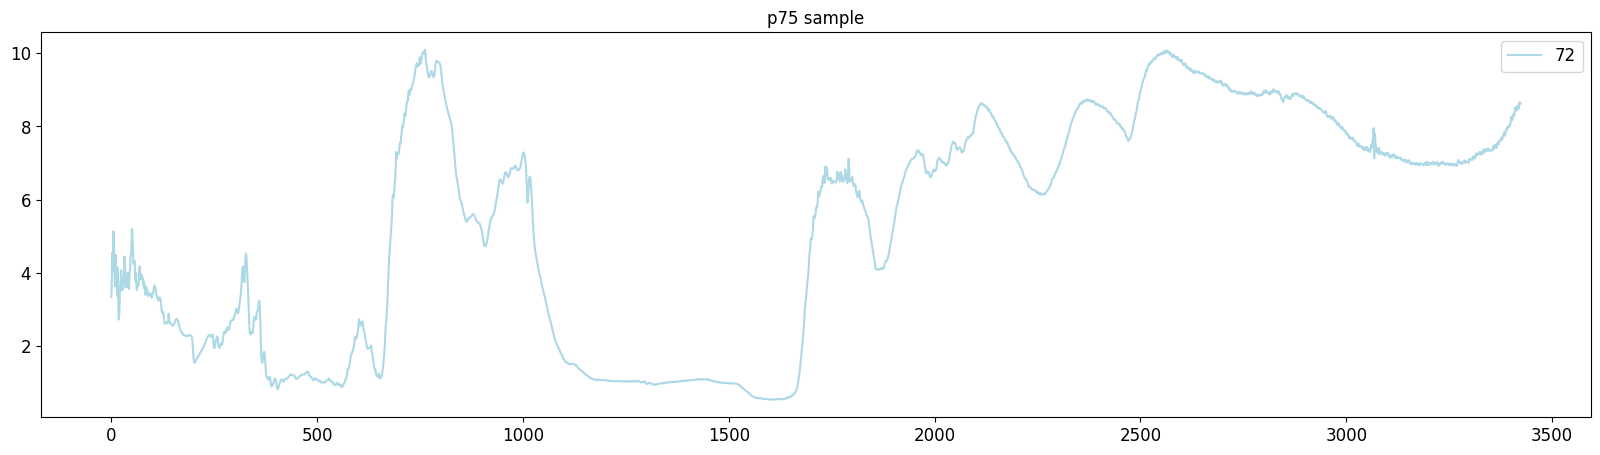

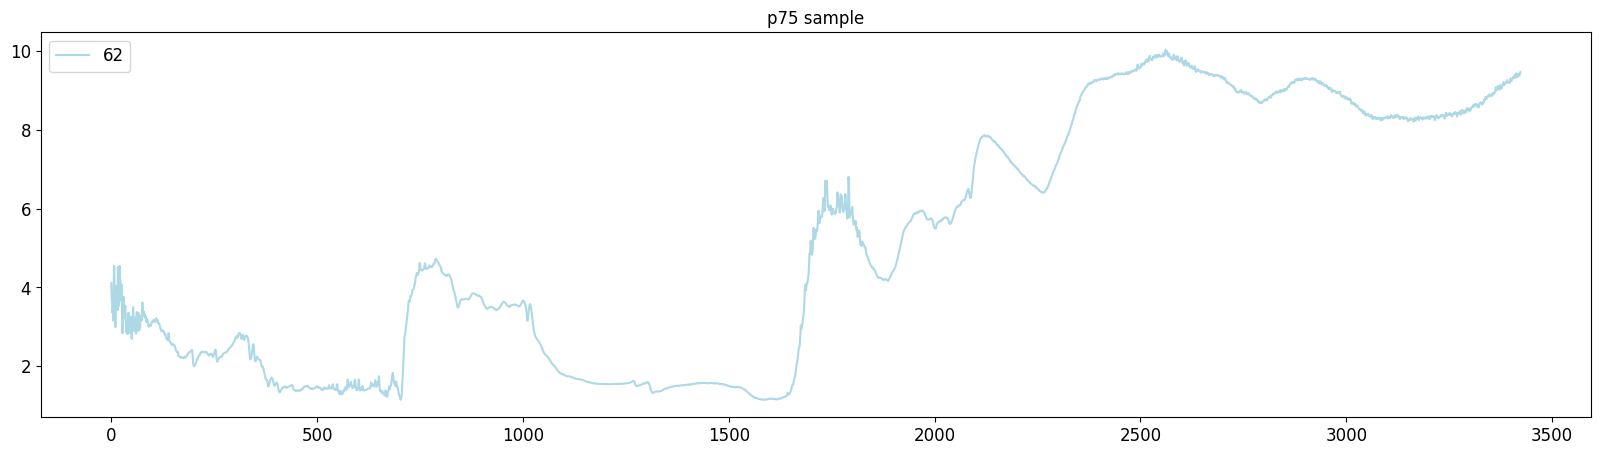

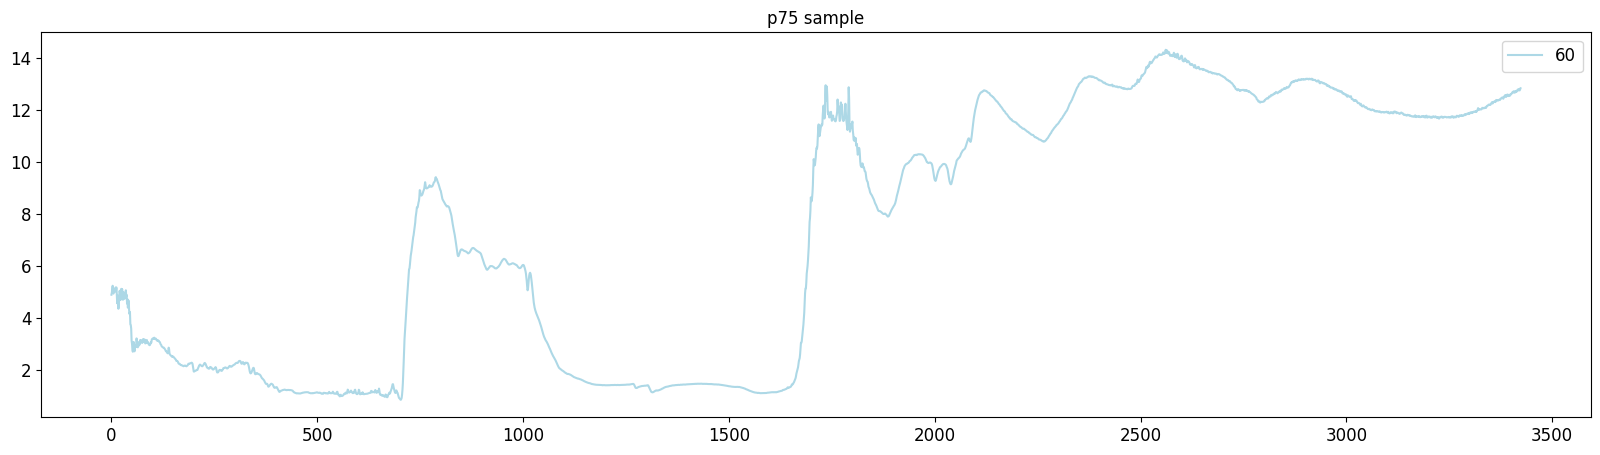

In [14]:
#pd.set_option('display.max_columns', 10)

#for sample in range(test_X.shape[0]):
for sample in range(3):
    print("sample:", sample)
    train_X_2d = convert_3d_to_2d_percentile(train_X, perc = 75)
    df = pd.DataFrame(train_X_2d[sample])
    #print(df)
    #print(df.describe().T)
    #print(train_y[sample])
    #plotWaves(df = df, features = df.columns, target = [str(train_y[sample])], out_file="plot_train_sample" + str(sample) + "-target" + str(train_y[sample]))
    #plotWaves(df = df, features = df.columns, target = ["NA"], out_file="plot_test_sample" + str(sample) + "-target-na")
    plt.figure(figsize=(20, 5))
    plt.plot(df, color='LightBlue')
    plt.title('p75 sample')
    target = [str(train_y[sample])]
    plt.legend(target)
    #plt.grid()
    out_file=str(target)+"p75_plot_sample.png"
    plt.savefig(out_file)


## TABULAR MODELS

## Concatenate all rows 

In [15]:
# try tabular models by concatenating all rows into a single array
models = [
    #LinearRegression(),
    #Ridge(),
    RidgeCV(),
    #RidgeCV(alphas=np.logspace(-3, 3, 10)),
    make_pipeline(
            StandardScaler(),
            RidgeCV(),
        ),
    #make_pipeline(VarianceThreshold(threshold=2.375211e+02),
    #        RidgeCV(),
    #    ),

   #  make_pipeline(SelectKBest(f_regression, k=10000),
   #         RidgeCV(),
   #     ),
    #make_pipeline(SelectKBest(mutual_info_regression, k=1000),
    #        RidgeCV(),
    #    ),
    #make_pipeline(SelectKBest(f_regression, k=1000),
    #        PolynomialFeatures(degree=2),
    #        RidgeCV(),
    #    ),
    
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            RidgeCV(),
        ),

    #ExtraTreesRegressor(n_estimators=100),

    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        ExtraTreesRegressor(n_estimators=100),
    #    ),
    #Lasso(),
    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        Lasso(),
    #    ),

   # make_pipeline(
   #         StandardScaler(),
   #         SelectFromModel(RidgeCV()),
   #         ElasticNet(),
   #     ),
    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        PolynomialFeatures(degree=2),
    #        RidgeCV(),
    #    ),
    
   # make_pipeline(VarianceThreshold(threshold=1.639303e+02),
   #         StandardScaler(),
   #         RidgeCV(),
   #     ),
   #KNeighborsRegressor(n_neighbors=1),
    KNeighborsRegressor(n_neighbors=5),
    #KNeighborsRegressor(n_neighbors=8),
    KNeighborsRegressor(n_neighbors=10),
    
    make_pipeline(VarianceThreshold(threshold=100.949228),
        KNeighborsRegressor(n_neighbors=5),
        ),
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            KNeighborsRegressor(n_neighbors=5),
        ),
    #MLPRegressor(), 
    #make_pipeline(
    #        StandardScaler(),
    #         MLPRegressor(), 
    #),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            StandardScaler(),
    #            MLPRegressor(), 
    #),
    
    #SVR(kernel='linear'), 
    
    #SVR(kernel='rbf'),

    #make_pipeline(
    #        StandardScaler(),
    #          SVR(kernel='rbf'),
    #),
    #Lasso(),
    #LassoCV(),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #        Lasso(),
    #    ),
    #make_pipeline(
    #        StandardScaler(),
    #        Lasso(),
    #    ),
    #ElasticNet(), 
    PLSRegression(n_components = 5),
    PLSRegression(n_components = 10),
    PLSRegression(n_components = 20),
    #PLSRegression(n_components = 30),
    
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            PLSRegression(n_components = 5),  
    #    ),
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            PLSRegression(n_components = 5),
        ),
    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        RandomForestRegressor(),
    #    ),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            RandomForestRegressor(n_estimators=100),
    #    ),
    #mord.LogisticAT(alpha=1.),
   
]

#clf2 = mord.LogisticAT(alpha=1.)
#clf2.fit(X, y)
#print('Mean Absolute Error of LogisticAT %s' %metrics.mean_absolute_error(clf2.predict(X), y))
algos_df = pd.DataFrame({"algo":[], "rmsecv": []})

if train_X.shape[0] > 1:
    train_X_2d = convert_3d_to_2d_concat(train_X)
    print(train_X_2d.shape)
    #print(train_X_2d[0,:])
    
    for rgr in models:
        print("\n", rgr)
        rmse, r2 = cv_experiment(train_X_2d, train_y, rgr, cv=4)
        print(f'RMSE: {rmse} - R2: {r2}')
        print(f'CV RMSE: {np.mean(rmse)} - CV R2: {np.mean(r2)}')
        #algos_df = algos_df.append({"percentile":str(percentile),"algo":str(algo), "rmsecv": np.mean(rmse)}, ignore_index=True)
        new_row = {"algo":str(rgr), "rmsecv": np.mean(rmse)}
        algos_df = pd.concat([algos_df, pd.DataFrame([new_row])], ignore_index=True)

        rgr.fit(train_X_2d, train_y)
        train_y_pred = rgr.predict(train_X_2d)
        rmse = math.sqrt(mean_squared_error(train_y, train_y_pred))
        r2 = r2_score(train_y, train_y_pred)
        print(f'RMSE: {rmse} - R2: {r2}')
        
        test_X_2d = convert_3d_to_2d_concat(test_X)
        y_pred_test = rgr.predict(test_X_2d)
        print(y_pred_test)

print(algos_df.sort_values('rmsecv'))
algos_df.sort_values('rmsecv').to_csv("tabular-concat" + "-rmsecv.csv")

    #plt.plot(y_pred,y_test)
    #r = np.corrcoef(y_pred, y_test)[0,1]
    #fig = px.scatter(training_df, x=y_pred, y=y_test,width=600, height=300)
    #fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="LightSteelBlue")
    #fig.show()

(64, 1027200)

 RidgeCV()
RMSE: [33.86 10.01 16.58 16.34] - R2: [-2.3   0.71  0.21  0.23]
CV RMSE: 19.19726235848018 - CV R2: -0.2886002348389219
RMSE: 0.00010844273564577652 - R2: 0.99999999996611
[56.34 68.44 42.64 71.62  6.39 49.31 36.04 40.94]

 Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())])
RMSE: [23.91 10.32 16.03 40.87] - R2: [-0.65  0.69  0.26 -3.81]
CV RMSE: 22.78307488134015 - CV R2: -0.8773799478278468
RMSE: 0.003528231737986738 - R2: 0.9999999641255931
[68.34 62.58 42.24 68.95  8.59 47.02 34.74 42.74]

 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfrommodel', SelectFromModel(estimator=RidgeCV())),
                ('ridgecv', RidgeCV())])
RMSE: [23.21 10.56 16.07 40.43] - R2: [-0.55  0.68  0.26 -3.71]
CV RMSE: 22.567074355165673 - CV R2: -0.8320758543115805
RMSE: 3.83429301192443e-05 - R2: 0.9999999999957632
[68.62 62.35 42.18 68.5   8.77 47.02 34.29 43.08]

 KNeighborsRegressor()


/Users/georgianaifrim/miniconda3/envs/comp47350py311/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


RMSE: [11.33 11.3  17.62 12.92] - R2: [0.63 0.63 0.11 0.52]
CV RMSE: 13.293703191820427 - CV R2: 0.47147514409221897
RMSE: 10.654107189248661 - R2: 0.6728818443804034
[59.6 52.  39.4 60.4 24.  57.6 49.  49.6]

 KNeighborsRegressor(n_neighbors=10)
RMSE: [12.5  11.53 16.54 13.02] - R2: [0.55 0.62 0.21 0.51]
CV RMSE: 13.400008502114803 - CV R2: 0.4722217219020173
RMSE: 11.65073093200594 - R2: 0.6088197946685878
[59.2 55.2 34.8 54.8 30.7 59.2 50.6 54.8]

 Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=100.949228)),
                ('kneighborsregressor', KNeighborsRegressor())])
RMSE: [11.55 10.42 17.   12.45] - R2: [0.62 0.69 0.17 0.55]
CV RMSE: 12.854528560308221 - CV R2: 0.5058249279538904
RMSE: 9.725546257151832 - R2: 0.7274171469740633
[60.4 56.8 39.4 57.6 25.  57.6 51.8 49.6]

 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfrommodel', SelectFromModel(estimator=RidgeCV())),
                ('kneighborsregressor', KNeighborsRegressor()

## Flatten the data to a percentile

In [16]:
# try tabular models by concatenating all rows into a single array
models = [
    #LinearRegression(),
    #Ridge(),
    RidgeCV(),
    #RidgeCV(alphas=np.logspace(-3, 3, 10)),
    make_pipeline(
            StandardScaler(),
            RidgeCV(),
        ),
    #make_pipeline(VarianceThreshold(threshold=2.375211e+02),
    #        RidgeCV(),
    #    ),

   #  make_pipeline(SelectKBest(f_regression, k=10000),
   #         RidgeCV(),
   #     ),
    #make_pipeline(SelectKBest(mutual_info_regression, k=1000),
    #        RidgeCV(),
    #    ),
    #make_pipeline(SelectKBest(f_regression, k=1000),
    #        PolynomialFeatures(degree=2),
    #        RidgeCV(),
    #    ),
    
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            RidgeCV(),
        ),

    ExtraTreesRegressor(n_estimators=100),

    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            ExtraTreesRegressor(n_estimators=100),
        ),
    #Lasso(),
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            Lasso(),
        ),

   # make_pipeline(
   #         StandardScaler(),
   #         SelectFromModel(RidgeCV()),
   #         ElasticNet(),
   #     ),
    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        PolynomialFeatures(degree=2),
    #        RidgeCV(),
    #    ),
    
   # make_pipeline(VarianceThreshold(threshold=1.639303e+02),
   #         StandardScaler(),
   #         RidgeCV(),
   #     ),
   #KNeighborsRegressor(n_neighbors=1),
    KNeighborsRegressor(n_neighbors=5),
    #KNeighborsRegressor(n_neighbors=8),
    KNeighborsRegressor(n_neighbors=10),
    
    make_pipeline(VarianceThreshold(threshold=100.949228),
        KNeighborsRegressor(n_neighbors=5),
        ),
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            KNeighborsRegressor(n_neighbors=5),
        ),
    #MLPRegressor(), 
    #make_pipeline(
    #        StandardScaler(),
    #         MLPRegressor(), 
    #),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            StandardScaler(),
    #            MLPRegressor(), 
    #),
    
    #SVR(kernel='linear'), 
    
    #SVR(kernel='rbf'),

    #make_pipeline(
    #        StandardScaler(),
    #          SVR(kernel='rbf'),
    #),
    #Lasso(),
    #LassoCV(),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #        Lasso(),
    #    ),
    #make_pipeline(
    #        StandardScaler(),
    #        Lasso(),
    #    ),
    #ElasticNet(), 
    PLSRegression(n_components = 5),
    PLSRegression(n_components = 10),
    #PLSRegression(n_components = 20),
    #PLSRegression(n_components = 30),
    
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            PLSRegression(n_components = 5),  
    #    ),
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            PLSRegression(n_components = 5),
        ),
    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        RandomForestRegressor(),
    #    ),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            RandomForestRegressor(n_estimators=100),
    #    ),
    #mord.LogisticAT(alpha=1.),
   
]

#clf2 = mord.LogisticAT(alpha=1.)
#clf2.fit(X, y)
#print('Mean Absolute Error of LogisticAT %s' %metrics.mean_absolute_error(clf2.predict(X), y))
algos_df = pd.DataFrame({"percentile":[], "algo":[], "rmsecv": []})

percentiles = [25, 50, 75]
for percentile in percentiles:
    print(percentile)
    if train_X.shape[0] > 1:
        train_X_2d = convert_3d_to_2d_percentile(train_X, perc = percentile)
    #train_X_2d = convert_3d_to_2d_concat(train_X)
        #test_x = convert_3d_to_2d(test_x)
        #print(train_X_2d.shape)
        #print(train_X_2d[0,:])
    
    for m in models:
        print("\n", m)
        rmse, r2 = cv_experiment(train_X_2d, train_y, m, cv=4)
        print(f'RMSE: {rmse} - R2: {r2}')
        print(f'CV RMSE: {np.mean(rmse)} - CV R2: {np.mean(r2)}')
        #algos_df = algos_df.append({"percentile":str(percentile),"algo":str(algo), "rmsecv": np.mean(rmse)}, ignore_index=True)
        new_row = {"percentile":str(percentile),"algo":str(m), "rmsecv": np.mean(rmse)}
        algos_df = pd.concat([algos_df, pd.DataFrame([new_row])], ignore_index=True)
        
        m.fit(train_X_2d, train_y)
        train_y_pred = m.predict(train_X_2d)
        rmse = math.sqrt(mean_squared_error(train_y, train_y_pred))
        r2 = r2_score(train_y, train_y_pred)
        print(f'RMSE: {rmse} - R2: {r2}')
        
        test_X_2d = convert_3d_to_2d_percentile(test_X, perc = percentile)
        y_pred_test = m.predict(test_X_2d)
        print(y_pred_test)
        
print(algos_df.sort_values('rmsecv'))
algos_df.sort_values('rmsecv').to_csv("tabular-percentiles" + "-rmsecv.csv")

    #plt.plot(y_pred,y_test)
    #r = np.corrcoef(y_pred, y_test)[0,1]
    #fig = px.scatter(training_df, x=y_pred, y=y_test,width=600, height=300)
    #fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="LightSteelBlue")
    #fig.show()

25

 RidgeCV()
RMSE: [14.8  10.74 19.37 12.41] - R2: [ 0.37  0.67 -0.08  0.56]
CV RMSE: 14.327545190936117 - CV R2: 0.3780457047744826
RMSE: 3.340706795043427 - R2: 0.9678376890765149
[64.67 62.55 45.26 66.77 39.28 49.76 38.81 34.52]

 Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())])
RMSE: [12.81 11.34 62.95  8.63] - R2: [  0.53   0.63 -10.42   0.79]
CV RMSE: 23.930099973146735 - CV R2: -2.1191423402200975
RMSE: 6.422482752447103 - R2: 0.881128862520229
[63.63 61.31 28.36 70.78 34.43 38.8  37.47 39.95]

 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfrommodel', SelectFromModel(estimator=RidgeCV())),
                ('ridgecv', RidgeCV())])
RMSE: [14.01 11.19 60.56  8.96] - R2: [ 0.43  0.64 -9.57  0.77]
CV RMSE: 23.680599332702833 - CV R2: -1.9315405690343286
RMSE: 6.452492581150783 - R2: 0.8800153875798101
[66.04 60.07 31.79 67.76 33.78 38.66 37.38 40.84]

 ExtraTreesRegressor()
RMSE: [ 9.78  7.43 13.96  9.65] - R2: [0.72 0.

/Users/georgianaifrim/miniconda3/envs/comp47350py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+00, tolerance: 2.221e+00
  model = cd_fast.enet_coordinate_descent(


[69.01 54.39 32.75 57.58 36.8  41.05 36.31 51.09]

 KNeighborsRegressor()
RMSE: [11.54 11.03 18.87 13.82] - R2: [ 0.62  0.65 -0.03  0.45]
CV RMSE: 13.816300005659459 - CV R2: 0.4221451729106629
RMSE: 10.484333550588707 - R2: 0.6832240634005764
[62.4 59.6 38.4 59.6 24.  57.6 32.6 52.4]

 KNeighborsRegressor(n_neighbors=10)
RMSE: [11.32 11.34 17.03 13.08] - R2: [0.63 0.63 0.16 0.51]
CV RMSE: 13.192122875006017 - CV R2: 0.48285077449567726
RMSE: 12.288218442882597 - R2: 0.5648405979827089
[61.2 55.  30.7 56.2 28.8 57.8 35.  53.6]

 Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=100.949228)),
                ('kneighborsregressor', KNeighborsRegressor())])
RMSE: [11.53 10.72 17.96 11.89] - R2: [0.62 0.67 0.07 0.59]
CV RMSE: 13.026007678536825 - CV R2: 0.48711275216138333
RMSE: 11.061588945535808 - R2: 0.6473811239193084
[60.8 57.2 38.4 57.6 29.8 58.  41.2 56.8]

 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfrommodel', SelectFromModel(est

/Users/georgianaifrim/miniconda3/envs/comp47350py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e+00, tolerance: 1.666e+00
  model = cd_fast.enet_coordinate_descent(


RMSE: [15.66  9.88 12.08 12.06] - R2: [0.29 0.72 0.58 0.58]
CV RMSE: 12.419439118558907 - CV R2: 0.5431187815447337
RMSE: 10.611996167897368 - R2: 0.675462643609601
[69.66 55.02 33.64 59.07 36.04 42.44 37.52 52.12]

 KNeighborsRegressor()
RMSE: [11.54 12.03 16.89 14.42] - R2: [0.62 0.58 0.18 0.4 ]
CV RMSE: 13.719109166390917 - CV R2: 0.44455691642651296
RMSE: 11.06537392047824 - R2: 0.6471397694524496
[65.6 52.4 38.4 59.6 25.  57.6 45.6 52.4]

 KNeighborsRegressor(n_neighbors=10)
RMSE: [12.59 12.11 16.76 12.82] - R2: [0.54 0.58 0.19 0.53]
CV RMSE: 13.57018087838795 - CV R2: 0.4593376260806917
RMSE: 12.011498397369081 - R2: 0.58421875
[63.8 56.2 34.8 56.2 30.7 57.8 41.7 56.2]

 Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=100.949228)),
                ('kneighborsregressor', KNeighborsRegressor())])
RMSE: [12.3  11.91 16.73 14.13] - R2: [0.56 0.59 0.19 0.42]
CV RMSE: 13.76704987047357 - CV R2: 0.44335014409221896
RMSE: 10.951369777338359 - R2: 0.6543731988472623
[64

## Flatten to subset of percentiles, then concatenate into a single vector

In [20]:
# try tabular models by concatenating all rows into a single array
random_state=42
models = [
    #LinearRegression(),
    #Ridge(),
    RidgeCV(),
    #RidgeCV(alphas=np.logspace(-3, 3, 10)),
    make_pipeline(
            StandardScaler(),
            RidgeCV(),
        ),
    #make_pipeline(VarianceThreshold(threshold=2.375211e+02),
    #        RidgeCV(),
    #    ),

   #  make_pipeline(SelectKBest(f_regression, k=10000),
   #         RidgeCV(),
   #     ),
    #make_pipeline(SelectKBest(mutual_info_regression, k=1000),
    #        RidgeCV(),
    #    ),
    #make_pipeline(SelectKBest(f_regression, k=1000),
    #        PolynomialFeatures(degree=2),
    #        RidgeCV(),
    #    ),
    
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            RidgeCV(),
        ),
    #Lasso(),
   # make_pipeline(
   #         StandardScaler(),
   #         SelectFromModel(RidgeCV()),
   #         Lasso(),
   #     ),

   # make_pipeline(
   #         StandardScaler(),
   #         SelectFromModel(RidgeCV()),
   #         ElasticNet(),
   #     ),
    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        PolynomialFeatures(degree=2),
    #        RidgeCV(),
    #    ),
    
   # make_pipeline(VarianceThreshold(threshold=1.639303e+02),
   #         StandardScaler(),
   #         RidgeCV(),
   #     ),
   #KNeighborsRegressor(n_neighbors=1),
   # KNeighborsRegressor(n_neighbors=5),
    #KNeighborsRegressor(n_neighbors=8),
    KNeighborsRegressor(n_neighbors=10),
    
    #make_pipeline(VarianceThreshold(threshold=100.949228),
    #    KNeighborsRegressor(n_neighbors=5),
    #    ),
    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        KNeighborsRegressor(n_neighbors=5),
    #    ),
    #MLPRegressor(), 
    #make_pipeline(
    #        StandardScaler(),
    #         MLPRegressor(), 
    #),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            StandardScaler(),
    #            MLPRegressor(), 
    #),
    
    #SVR(kernel='linear'), 
    
    #SVR(kernel='rbf'),

    #make_pipeline(
    #        StandardScaler(),
    #          SVR(kernel='rbf'),
    #),
    #Lasso(),
    #LassoCV(),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #        Lasso(),
    #    ),
    #make_pipeline(
    #        StandardScaler(),
    #        Lasso(),
    #    ),
    #ElasticNet(), 
    #PLSRegression(n_components = 5),
    PLSRegression(n_components = 10),
    #PLSRegression(n_components = 20),
    #PLSRegression(n_components = 30),
    
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            PLSRegression(n_components = 5),  
    #    ),
    make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            PLSRegression(n_components = 10),
        ),
    make_pipeline(
            Rocket(random_state=random_state, normalise=True),
            StandardScaler(),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),

    make_pipeline(
            Rocket(random_state=42, normalise=True),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            #RidgeCV(alphas=np.logspace(-3, 3, 10)),
            ExtraTreesRegressor(n_estimators=100),
        ),

    #make_pipeline(
    #        StandardScaler(),
    #        SelectFromModel(RidgeCV()),
    #        RandomForestRegressor(),
    #    ),
    #make_pipeline(VarianceThreshold(threshold=1.639303e+02),
    #            RandomForestRegressor(n_estimators=100),
    #    ),
    #mord.LogisticAT(alpha=1.),
   
]

#clf2 = mord.LogisticAT(alpha=1.)
#clf2.fit(X, y)
#print('Mean Absolute Error of LogisticAT %s' %metrics.mean_absolute_error(clf2.predict(X), y))
algos_df = pd.DataFrame({"percentile":[], "algo":[], "rmsecv": []})

train_X_subset = convert_3d_to_3d_subset(train_X, percentiles = [25, 50, 75], add_mean = False)
print(train_X_subset.shape)
train_X_2d = convert_3d_to_2d_concat(train_X_subset)
print(train_X_2d.shape)

percentile="25-50-75"
for m in models:
    print("\n", m)

    rmse, r2 = cv_experiment(train_X_2d, train_y, m, cv=4)
    print(f'RMSE: {rmse} - R2: {r2}')
    print(f'CV RMSE: {np.mean(rmse)} - CV R2: {np.mean(r2)}')
        #algos_df = algos_df.append({"percentile":str(percentile),"algo":str(algo), "rmsecv": np.mean(rmse)}, ignore_index=True)
    new_row = {"percentile":str(percentile),"algo":str(m), "rmsecv": np.mean(rmse)}
    algos_df = pd.concat([algos_df, pd.DataFrame([new_row])], ignore_index=True)
        
print(algos_df.sort_values('rmsecv'))
algos_df.sort_values('rmsecv').to_csv("tabular-percentiles" + "-rmsecv.csv")

    #plt.plot(y_pred,y_test)
    #r = np.corrcoef(y_pred, y_test)[0,1]
    #fig = px.scatter(training_df, x=y_pred, y=y_test,width=600, height=300)
    #fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="LightSteelBlue")
    #fig.show()

(64, 3, 3424)
(64, 10272)

 RidgeCV()
RMSE: [ 7.47 10.83 12.41 12.58] - R2: [0.84 0.66 0.56 0.54]
CV RMSE: 10.824510935755416 - CV R2: 0.6502122431756772

 Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())])
RMSE: [7.84 8.18 7.97 5.89] - R2: [0.82 0.81 0.82 0.9 ]
CV RMSE: 7.467674799621225 - CV R2: 0.8368492421114947

 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectfrommodel', SelectFromModel(estimator=RidgeCV())),
                ('ridgecv', RidgeCV())])
RMSE: [7.68 7.71 7.7  5.77] - R2: [0.83 0.83 0.83 0.9 ]
CV RMSE: 7.2135534592455475 - CV R2: 0.8480536616806449

 KNeighborsRegressor(n_neighbors=10)
RMSE: [11.42 11.48 16.91 12.94] - R2: [0.62 0.62 0.18 0.52]
CV RMSE: 13.18471196253121 - CV R2: 0.4846609329971182

 PLSRegression(n_components=10)
RMSE: [8.45 7.39 7.88 6.94] - R2: [0.79 0.84 0.82 0.86]
CV RMSE: 7.666835332786334 - CV R2: 0.8296868312351565

 Pipeline(steps=[('standardscaler', StandardScaler()),
                (

## TIME SERIES

## UNIVARIATE

## Flatten the 2d time series to a single percentile 1d time series

In [21]:
random_state = 42
models = [
        make_pipeline(
            Rocket(random_state=random_state, normalise=True),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),
        make_pipeline(
            Rocket(random_state=random_state, normalise=True),
            StandardScaler(),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),
        make_pipeline(
            Rocket(random_state=random_state, normalise=True),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),

            make_pipeline(
            Rocket(random_state=random_state, normalise=True),
            StandardScaler(),
            #RidgeCV(alphas=np.logspace(-3, 3, 10)),
            ExtraTreesRegressor(n_estimators=100),
        ),

            make_pipeline(
            Rocket(random_state=random_state, normalise=True),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            #RidgeCV(alphas=np.logspace(-3, 3, 10)),
            ExtraTreesRegressor(n_estimators=100),
        ),
  
        RidgeCV(),
        make_pipeline(
            StandardScaler(),
            RidgeCV(),
        ),
        make_pipeline(
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            RidgeCV(),
        ),
        #KNeighborsRegressor(n_neighbors=10),
        #make_pipeline(
        #    MiniRocket(random_state=random_state),
        #    StandardScaler(),
        #    RidgeCV(alphas=np.logspace(-3, 3, 10)),
        #),
       # make_pipeline(
       #     MultiRocket(random_state=random_state),
       #     StandardScaler(),
       #     RidgeCV(alphas=np.logspace(-3, 3, 10)),
       # ),
        #RDSTRegressor(),
        #RDSTRegressor(),
        #RISTRegressor(n_jobs=-1, random_state=random_state),
    
        #make_pipeline(
          #  StandardScaler(),
        #   TimeSeriesForestRegressor()
        #),
          # DrCIFRegressor()

]

algos_df = pd.DataFrame({"percentile":[], "algo":[], "rmsecv": []})

percentiles = [25, 50, 75]
for percentile in percentiles:
    print(percentile)
    if train_X.shape[0] > 1:
        train_X_2d = convert_3d_to_2d_percentile(train_X, perc = percentile)
        #train_X_2d = convert_3d_to_2d_mean(train_X)
        #train_X_2d = convert_3d_to_2d_percentile(X_selected, perc = percentile)
        #train_X_2d = convert_3d_to_2d_concat(train_X)
        #test_x = convert_3d_to_2d(test_x)
        #print(train_X_2d.shape)
        #print(train_X_2d[0,:])
    
    for m in models:
        print("\n", m)
        starttime = timeit.default_timer()
        rmse, r2 = cv_experiment(train_X_2d, train_y, m, cv=4)
        print(f'RMSE: {rmse} - R2: {r2}')
        print(f'CV RMSE: {np.mean(rmse)} - CV R2: {np.mean(r2)}')
        #algos_df = algos_df.append({"percentile":str(percentile),"algo":str(algo), "rmsecv": np.mean(rmse)}, ignore_index=True)
        new_row = {"percentile":str(percentile),"algo":str(m), "rmsecv": np.mean(rmse)}
        algos_df = pd.concat([algos_df, pd.DataFrame([new_row])], ignore_index=True)
        print("Time to train + test (sec):", timeit.default_timer() - starttime)

        m.fit(train_X_2d, train_y)
        train_y_pred = m.predict(train_X_2d)
        rmse = math.sqrt(mean_squared_error(train_y, train_y_pred))
        r2 = r2_score(train_y, train_y_pred)
        print(f'RMSE: {rmse} - R2: {r2}')
        
        test_X_2d = convert_3d_to_2d_percentile(test_X, perc = percentile)
        y_pred_test = m.predict(test_X_2d)
        print(y_pred_test)        
        
print(algos_df.sort_values('rmsecv'))
#algos_df.sort_values('rmsecv').to_csv("UTS-percentiles" + "-rmsecv.csv")

25

 Pipeline(steps=[('rocket', Rocket(random_state=42)),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00e-03, 4.64e-03, 2.15e-02, 1.00e-01, 4.64e-01, 2.15e+00,
       1.00e+01, 4.64e+01, 2.15e+02, 1.00e+03])))])
RMSE: [7.38 8.29 8.98 7.31] - R2: [0.84 0.8  0.77 0.85]
CV RMSE: 7.99052615356956 - CV R2: 0.8146185585471403
Time to train + test (sec): 80.06177009700332
RMSE: 3.727752286364613 - R2: 0.9599534953645631
[80.42 65.63 34.23 61.35 20.25 47.88 40.55 29.63]

 Pipeline(steps=[('rocket', Rocket(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00e-03, 4.64e-03, 2.15e-02, 1.00e-01, 4.64e-01, 2.15e+00,
       1.00e+01, 4.64e+01, 2.15e+02, 1.00e+03])))])
RMSE: [4.53 5.14 4.88 5.61] - R2: [0.94 0.92 0.93 0.91]
CV RMSE: 5.038993352982048 - CV R2: 0.9263797447379365
Time to train + test (sec): 85.98904645699076
RMSE: 7.523934894123677e-06 - R2: 0.9999999999998369
[74.77 65.

KeyboardInterrupt: 

In [ ]:
random_state = 42

rgr = make_pipeline(
            Rocket(random_state=random_state, normalise=True),
            StandardScaler(),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        )

#rgr =  KNeighborsRegressor(n_neighbors=10)

percentiles = ["mean"]
for percentile in percentiles:
    print(percentile)

    
    if train_X.shape[0] > 1:
        #train_X_2d = convert_3d_to_2d_percentile(train_X, perc = percentile)
        train_X_2d = convert_3d_to_2d_mean(train_X)
        #train_X_2d = convert_3d_to_2d_percentile(X_selected, perc = percentile)
        #train_X_2d = convert_3d_to_2d_concat(train_X)
        #test_x = convert_3d_to_2d(test_x)
        #print(train_X_2d.shape)
        #print(train_X_2d[0,:])

        rgr.fit(train_X_2d, train_y)
        train_y_pred = rgr.predict(train_X_2d)
        rmse = math.sqrt(mean_squared_error(train_y, train_y_pred))
        r2 = r2_score(train_y, train_y_pred)
        print(f'RMSE: {rmse} - R2: {r2}')
        
        #test_X_2d = convert_3d_to_2d_percentile(test_X, perc = percentile)
        test_X_2d = convert_3d_to_2d_mean(test_X)
        y_pred_test = rgr.predict(test_X_2d)
        print(y_pred_test)       
'''        
72    8
62    8
60    8
48    8
24    8
58    8
29    8
19    8
'''
y_test_human = [72, 62, 24, 62, 29, 58, 48, 19]

## Best Model

In [62]:
percentiles = [75]

for i in range(0, 1):
    
    rgr = make_pipeline(
            Rocket(normalise=True, num_kernels=10000, n_jobs=-1, random_state=142),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            ExtraTreesRegressor(n_estimators=100, random_state=142),
            #RandomForestRegressor(n_estimators=100, random_state=142),
                
        )

    for percentile in percentiles:
        starttime = timeit.default_timer()
        print(percentile)
        if train_X.shape[0] > 1:
            train_X_2d = convert_3d_to_2d_percentile(train_X, perc = percentile)
            print("\n", rgr)
            rmse, r2 = cv_experiment(train_X_2d, train_y, rgr, cv=4)
            print(f'RMSE: {rmse} - R2: {r2}')
            print(f'CV RMSE: {np.mean(rmse)} - CV R2: {np.mean(r2)}')
            print("Time to train + test (sec):", timeit.default_timer() - starttime)

            starttime = timeit.default_timer()
            rgr.fit(train_X_2d, train_y)
            train_y_pred = rgr.predict(train_X_2d)
            rmse = math.sqrt(mean_squared_error(train_y, train_y_pred))
            r2 = r2_score(train_y, train_y_pred)
            print(f'RMSE: {rmse} - R2: {r2}')
        
            test_X_2d = convert_3d_to_2d_percentile(test_X, perc = percentile)
            #test_X_2d = pd.DataFrame(savgol_filter(test_X_2d, window_length = 5, polyorder = 2, deriv=0, axis=1))
            y_pred_test = rgr.predict(test_X_2d)
            print(y_pred_test)        
            print("Time to train + test (sec):", timeit.default_timer() - starttime)
#y_test_human = [72, 60, 24, 62, 29, 58, 48, 19]

75

 Pipeline(steps=[('rocket', Rocket(n_jobs=-1, random_state=142)),
                ('standardscaler', StandardScaler()),
                ('selectfrommodel', SelectFromModel(estimator=RidgeCV())),
                ('extratreesregressor', ExtraTreesRegressor(random_state=142))])
RMSE: [4.02 5.13 5.36 3.29] - R2: [0.95 0.92 0.92 0.97]
CV RMSE: 4.449414508590474 - CV R2: 0.9409093659942364
Time to train + test (sec): 38.73212733998662
RMSE: 0.0 - R2: 1.0
[71.86 59.64 53.14 60.24 22.78 51.52 49.24 23.8 ]
Time to train + test (sec): 21.39173465501517


In [60]:
print(train_X_2d.shape)
# apply ROCKET transform to create a vector with 20k features
rgr1 = Rocket(normalise=True, num_kernels=10000, n_jobs=-1, random_state=142)
X1 = rgr1.fit_transform(train_X_2d)
print(rgr1)
print(rgr1.get_params())
print(X1.shape)
#scale the 20k features
rgr2 = StandardScaler()
X2 = rgr2.fit_transform(X1)
print(rgr2)
print(X2.shape)
#apply feature selection to reduce the 20k features to a subset
rgr3 = SelectFromModel(RidgeCV())
X3 = rgr3.fit_transform(X2, train_y)
print(rgr3)
print(X3.shape)
#look at how many features are selected using SelectFromModel()
print("threshold: ", rgr3.threshold_)
print("number of selected features: ", rgr3.get_support().sum())
#Train an ExtraTrees ensemble with the feature subset
rgr4 =  ExtraTreesRegressor(n_estimators=100, random_state=142)
rgr4.fit(X3, train_y)
print(rgr4)
# and the feature importance from ExtraTrees ensemble
#feature_idx = [i for i in range(1,train_X_2d.shape[1]+1)]
#print(feature_idx)
#feature_importance = pd.DataFrame({'feature': feature_idx, 'importance':rgr4.feature_importances_})
feature_importance = pd.DataFrame({'importance':rgr4.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False))
#print(feature_importance.sort_values('importance', ascending=False)[:10])
print((feature_importance['importance'] != 0).sum())

(64, 3424)
Rocket(n_jobs=-1, random_state=142)
{'n_jobs': -1, 'normalise': True, 'num_kernels': 10000, 'random_state': 142}
(64, 20000)
StandardScaler()
(64, 20000)
SelectFromModel(estimator=RidgeCV())
(64, 7610)
threshold:  0.006831045806043519
number of selected features:  7610
ExtraTreesRegressor(random_state=142)
      importance
3768    0.052522
4098    0.035022
5365    0.035014
6068    0.026909
3910    0.026261
...          ...
9       0.000000
7606    0.000000
8       0.000000
7608    0.000000
7       0.000000

[7610 rows x 1 columns]
922


In [ ]:
from sklearn.ensemble import VotingRegressor

rgr_list = []
for i in range(0,5):
    rgr_single = make_pipeline(
            make_pipeline(
            Rocket(normalise=True, num_kernels=10000, n_jobs=-1),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            #RidgeCV(alphas=np.logspace(-3, 3, 10)),
            ExtraTreesRegressor(n_estimators=100),
        ))
    rgr_list.append(("rgr"+str(i),rgr_single))

#print(rgr_list)

rgr =  VotingRegressor(estimators=rgr_list)

for percentile in [75]:
    print(percentile)
    if train_X.shape[0] > 1:
        train_X_2d = convert_3d_to_2d_percentile(train_X, perc = percentile)
        #train_X_2d = pd.DataFrame(savgol_filter(train_X_2d, window_length = 5, polyorder = 2, deriv=0, axis=1))
        
        print("\n", rgr)
        rmse, r2 = cv_experiment(train_X_2d, train_y, rgr, cv=4)
        print(f'RMSE: {rmse} - R2: {r2}')
        print(f'CV RMSE: {np.mean(rmse)} - CV R2: {np.mean(r2)}')
        
        rgr.fit(train_X_2d, train_y)
        train_y_pred = rgr.predict(train_X_2d)
        rmse = math.sqrt(mean_squared_error(train_y, train_y_pred))
        r2 = r2_score(train_y, train_y_pred)
        print(f'RMSE: {rmse} - R2: {r2}')
        
        test_X_2d = convert_3d_to_2d_percentile(test_X, perc = percentile)
        #test_X_2d = pd.DataFrame(savgol_filter(test_X_2d, window_length = 5, polyorder = 2, deriv=0, axis=1))
        y_pred_test = rgr.predict(test_X_2d)
        print(y_pred_test)        

## MULTIVARIATE 

## All channels

In [ ]:
random_state = 42
models = [
        make_pipeline(
            Rocket(random_state=random_state),
            StandardScaler(),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),
        make_pipeline(
            MiniRocketMultivariate(random_state=random_state),
            StandardScaler(),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),
        make_pipeline(
            MultiRocketMultivariate(random_state=random_state),
            StandardScaler(),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),
]

for m in models:
    print(m)
    rmse, r2, y_pred, y_test = single_split_experiment(train_X, train_y, m, stratify = train_y)
    print(f'RMSE: {rmse} - R2: {r2}')

    actual_vs_predicted = pd.concat([y_test, pd.DataFrame(y_pred, columns=['Predicted'], index=y_test.index)], axis=1)
    print(actual_vs_predicted)

Pipeline(steps=[('rocket', Rocket(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00e-03, 4.64e-03, 2.15e-02, 1.00e-01, 4.64e-01, 2.15e+00,
       1.00e+01, 4.64e+01, 2.15e+02, 1.00e+03])))])


In [ ]:
random_state = 42
models = [
    
    make_pipeline(
            Rocket(random_state=random_state),
            StandardScaler(),
            RidgeCV(),
        ),
    
        make_pipeline(
            Rocket(random_state=random_state),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            RidgeCV(),
        ),

         make_pipeline(
            Rocket(random_state=random_state),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            #RidgeCV(alphas=np.logspace(-3, 3, 10)),
            ExtraTreesRegressor(n_estimators=100),
        ),
        '''
        make_pipeline(
            MiniRocketMultivariate(random_state=random_state),
            #StandardScaler(),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),
        make_pipeline(
            MultiRocketMultivariate(random_state=random_state),
            #StandardScaler(),
            RidgeCV(alphas=np.logspace(-3, 3, 10)),
        ),
        '''
]

for m in models:
    print(m)
    starttime = timeit.default_timer()
    rmse, r2 = cv_experiment(train_X, train_y, m, cv=4)
    print(f'RMSE: {rmse} - R2: {r2}')
    print(f'CV RMSE: {np.mean(rmse)} - CV R2: {np.mean(r2)}')


    m.fit(train_X, train_y)
    train_y_pred = m.predict(train_X)
    rmse = math.sqrt(mean_squared_error(train_y, train_y_pred))
    r2 = r2_score(train_y, train_y_pred)
    print(f'RMSE: {rmse} - R2: {r2}')
        
    y_pred_test = m.predict(test_X)
    print(y_pred_test)     
    print("Time to train + test (sec):", timeit.default_timer() - starttime)

## Using a subset of channels: select [p25, p50, p75] percentiles

In [ ]:
#reduce the MTS to a subset including a few percentiles to remove the impact of outliers
random_state = 42
models = [
      make_pipeline(
            Rocket(random_state=random_state, normalise=True),
            StandardScaler(),
            SelectFromModel(estimator=RidgeCV()),
            RidgeCV(),
        ),
    
        # make_pipeline(
        #    HydraTransformer(),
        #    StandardScaler(),
        #    SelectFromModel(estimator=RidgeCV()), 
        #    RidgeCV(alphas=np.logspace(-3, 3, 10)),
        #),
    make_pipeline(
            Rocket(random_state=random_state),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            #RidgeCV(alphas=np.logspace(-3, 3, 10)),
            ExtraTreesRegressor(),
        ),
#        make_pipeline(
#            StandardScaler(),
#            SelectFromModel(estimator=RidgeCV()),
#           DrCIFRegressor()
#        ),
 #       RISTRegressor()
       # make_pipeline(
       #     MiniRocketMultivariate(random_state=random_state),
            #StandardScaler(),
       #     RidgeCV(alphas=np.logspace(-3, 3, 10)),
       # ),
       # make_pipeline(
       #     MultiRocketMultivariate(random_state=random_state),
            #StandardScaler(),
       #     RidgeCV(alphas=np.logspace(-3, 3, 10)),
        #),
]
percentiles = [25, 50, 75]
train_X_subset = convert_3d_to_3d_subset(train_X, percentiles = [25, 50, 75], add_mean = False)
test_X_subset = convert_3d_to_3d_subset(test_X, percentiles = [25, 50, 75], add_mean = False)
print(train_X_subset.shape)
print(percentiles)
algos_df = pd.DataFrame({"percentile":[], "algo":[], "rmsecv": []})

for m in models:
    print(m)
    starttime = timeit.default_timer()
    rmse, r2 = cv_experiment(train_X_subset, train_y, m, cv=4)
    print(f'RMSE: {rmse} - R2: {r2}')
    print(f'CV RMSE: {np.mean(rmse)} - CV R2: {np.mean(r2)}')
    new_row = {"percentile":str(percentiles),"algo":str(m), "rmsecv": np.mean(rmse)}
    algos_df = pd.concat([algos_df, pd.DataFrame([new_row])], ignore_index=True)
    print("Time to train + test (sec):", timeit.default_timer() - starttime)

    m.fit(train_X_subset, train_y)
    train_y_pred = m.predict(train_X_subset)
    rmse = math.sqrt(mean_squared_error(train_y, train_y_pred))
    r2 = r2_score(train_y, train_y_pred)
    print(f'RMSE: {rmse} - R2: {r2}')

    y_pred_test = m.predict(test_X_subset)
    print(y_pred_test)     
        
print(algos_df.sort_values('rmsecv'))